#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 644 #37 #98 #190 #61 #37 #46
# N_CLASSES= 9
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset"
SAMPLE_DATASET_NAME = "m2m_twin_train" + ".csv"
ACTUAL_DATASET_NAME = "m2m_tengraph_test" + ".csv"

# SAMPLE_DATASET_NAME = "train_m2m_tengraph" + ".csv"
# ACTUAL_DATASET_NAME = "test_m2m_tengraph" + ".csv"

# SAMPLE_DATASET_NAME = "andy" + ".csv"
# ACTUAL_DATASET_NAME = "andy" + ".csv"

MODEL_DIR_NAME = "model"
MODEL_NAME = "classifier" + ".h5"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3 #6 #4
CLASS_LIST = ['andy', 'cy', 'gerald', 'jc', 'jonah', 'qk']
# CLASS_LIST = ['andy', 'azfar', 'gerald', 'jonah', 'ys']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

def df_drop(df):
    # df.drop(df[df['Subject']=='andy'].index, inplace=True)
    # df.drop(df[df['Subject']=='azfar'].index, inplace=True)
    df.drop(df[df['Subject']=='ch'].index, inplace=True)
    # df.drop(df[df['Subject']=='cy'].index, inplace=True)
    df.drop(df[df['Subject']=='gerald'].index, inplace=True)
    df.drop(df[df['Subject']=='jc'].index, inplace=True)
    df.drop(df[df['Subject']=='jonah'].index, inplace=True)
    df.drop(df[df['Subject']=='qikai'].index, inplace=True)
    df.drop(df[df['Subject']=='ys'].index, inplace=True)
    df.drop(df[df['Subject']=='zen'].index, inplace=True)
    
    return df

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\dataset
Model directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\model


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
# create base model
def create_base_model():
    model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, 
#                  input_shape=(TIMESTEPS,N_FEATURES)))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    model.add(LSTM(units=1024, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model



In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### CHECK DATASET

In [7]:
#     sns.catplot(x="Subject", y="D|0", data=df)

    
#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|3", hue="D|3", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|4", hue="D|4", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|5", hue="D|5", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|6", hue="D|6", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|7", hue="D|7", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|8", hue="D|8", data=df, legend=False)

#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="I|1+2", hue="I|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="PF|1+2", hue="PF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="RF|1+2", hue="RF|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="DT|1+2", hue="DT|1+2", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|9", hue="D|9", data=df, legend=False)


#     sns.catplot(x="Subject", y="TT|1+3", hue="TT|1+3", data=df, legend=False)
#     sns.catplot(x="Subject", y="QT|1+4", hue="QT|1+4", data=df, legend=False)

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [8]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

# df = df_drop(df)
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'qk']


X | Features | Dataset Shape: (76176, 644)
Y | Classes  | Dataset Shape: (76176, 7)
7
Epoch 1/200
762/762 [==============================] - 65s 67ms/step - loss: 0.7368 - accuracy: 0.7281
Epoch 2/200
762/762 [==============================] - 53s 69ms/step - loss: 0.5759 - accuracy: 0.7873
Epoch 3/200
762/762 [==============================] - 53s 69ms/step - loss: 0.5217 - accuracy: 0.8078
Epoch 4/200
762/762 [==============================] - 52s 69ms/step - loss: 0.4878 - accuracy: 0.8206
Epoch 5/200
762/762 [==============================] - 53s 70ms/step - loss: 0.4620 - accuracy: 0.8286
Epoch 6/200
762/762 [==============================] - 51s 67ms/step - loss: 0.4390 - accuracy: 0.8386
Epoch 7/200
762/762 [==============================] - 53s 69ms/step - loss: 0.4052 - accuracy: 0.8512
Epoch 8/200
762/762 [==============================] - 55s 73ms/step - loss: 0.3885 - accuracy: 0.8562
Ep

762/762 [==============================] - 56s 73ms/step - loss: 0.0700 - accuracy: 0.9778
Epoch 78/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0763 - accuracy: 0.9757
Epoch 79/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0760 - accuracy: 0.9761
Epoch 80/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0728 - accuracy: 0.9764
Epoch 81/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0713 - accuracy: 0.9770
Epoch 82/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0813 - accuracy: 0.9745
Epoch 83/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0707 - accuracy: 0.9778
Epoch 84/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0692 - accuracy: 0.9786
Epoch 85/200
762/762 [==============================] - 56s 73ms/step - loss: 0.0674 - accuracy: 0.9787
Epoch 86/200
762/762 [==============================] - 56s 73ms/step - loss:

762/762 [==============================] - 97s 128ms/step - loss: 0.0626 - accuracy: 0.9803
Epoch 156/200
762/762 [==============================] - 98s 128ms/step - loss: 0.0564 - accuracy: 0.9823
Epoch 157/200
762/762 [==============================] - 98s 129ms/step - loss: 0.0631 - accuracy: 0.9807
Epoch 158/200
762/762 [==============================] - 98s 129ms/step - loss: 0.0748 - accuracy: 0.9772
Epoch 159/200
762/762 [==============================] - 100s 131ms/step - loss: 0.0632 - accuracy: 0.9810
Epoch 160/200
762/762 [==============================] - 98s 129ms/step - loss: 0.0721 - accuracy: 0.9778
Epoch 161/200
762/762 [==============================] - 101s 133ms/step - loss: 0.0523 - accuracy: 0.9839
Epoch 162/200
762/762 [==============================] - 103s 136ms/step - loss: 0.0542 - accuracy: 0.9833
Epoch 163/200
762/762 [==============================] - 103s 135ms/step - loss: 0.0564 - accuracy: 0.9827
Epoch 164/200
762/762 [==============================] -

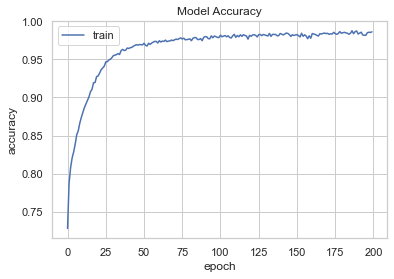

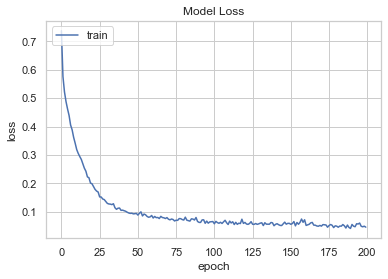

In [9]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [10]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [11]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [12]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()
# pred_df = df_drop(pred_df)

,Subject,Seq_No,Sequence,D|0,I|0+1,PF|0+1,RF|0+1,DT|0+1,D|1,I|1+2,...,T9-RF-VAR.1,T9-G-VAR.1,T9-I-SD.1,T9-PF-SD.1,T9-RF-SD.1,T9-G-SD.1,T10_I|0+9.1,T10_PF|0+9.1,T10_RF|0+9.1,T10_G|0+9.1
0,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.000040,0.000103,0.002687,0.001119,0.006321,0.010128,1.022713,1.199032,1.199656,1.375975
1,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.010145,0.008453,0.077343,0.068562,0.100724,0.091942,0.708511,0.823514,0.887639,1.002642
2,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.001819,0.003063,0.066153,0.078847,0.042655,0.055349,0.674672,0.829957,0.804220,0.959506
3,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.005348,0.008820,0.067350,0.088133,0.073132,0.093915,1.032329,1.207123,1.203380,1.378173
4,andy,3,bob hacker,0.109653,-0.041265,0.068388,0.124682,0.234335,0.165948,-0.039421,...,0.003408,0.000581,0.058742,0.024466,0.058379,0.024103,0.887826,1.028076,1.016688,1.156938


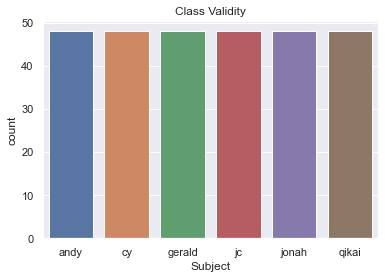

In [13]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [14]:
pred_dataset = pred_df.values
results = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = CLASS_LIST
print(Y)
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [16]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))
pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
# df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

df.to_csv("results_twin.csv")

    Results Prediction    Accuracy
0      andy       andy   0.9999949
1      andy       andy   0.9999994
2      andy       andy   0.9999994
3      andy       andy   0.9999993
4      andy       andy   0.9999993
5      andy       andy   0.9999995
6      andy       andy    0.998376
7      andy       andy   0.9999994
8      andy       andy   0.9999993
9      andy       andy   0.9999994
10     andy       andy   0.9999994
11     andy       andy   0.9999995
12     andy       andy  0.99999845
13     andy       andy   0.6296454
14     andy       andy   0.9999405
15     andy       andy    0.999997
16     andy       andy  0.99991286
17     andy       andy   0.9999988
18     andy       andy   0.9999995
19     andy       andy   0.9999993
20     andy       andy   0.9999995
21     andy       andy   0.9999993
22     andy       andy   0.9999994
23     andy       andy   0.9999995
24     andy       andy   0.9999902
25     andy       andy   0.9999101
26     andy       andy   0.9998833
27     andy       an